In [1]:
import librosa, librosa.display
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

path = "audio/"
min_samples = 22050

In [3]:
waveforms = []
ffts = []
stfts = [] 
f_ffts = []
log_specs = []
MFCCs_list = []


def extract_MFCCs(signal, sample_rate):
    waveforms.append([signal, sample_rate]) 
    # FFT -> power spectrum
    # perform Fourier transform
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))
    f_ffts.append([frequency, magnitude])
    
    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)
    
    # half frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    
    ffts.append([left_f, left_spectrum])
    
    num_mfcc=13 
    n_fft=2048
    hop_length=512
    
    #performing Short-time FT
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    
    stfts.append([spectrogram, sample_rate, hop_length])
    
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    log_specs.append([log_spectrogram, sample_rate, hop_length])
    
    MFCCs = librosa.feature.mfcc(signal, sample_rate, 
                                 n_mfcc=num_mfcc, n_fft=n_fft,
                                 hop_length=hop_length)
    MFCCs_list.append([MFCCs, sample_rate, hop_length])
    return MFCCs



def preprocess_dataset(dataset_path):
    data = {
        "mapping": [],
        "labels": [],
        "MFCCs": [],
        "files": []
    } 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:
            label = dirpath.split("/")[-1]
            data["mapping"].append(label)
            print("\nProcessing: '{}'".format(label))

            # process all audio files in sub-dir and store MFCCs
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path)
                if len(signal) >= min_samples:

                    signal = signal[:min_samples]

                    MFCCs = extract_MFCCs(signal, sample_rate)

                    data["MFCCs"].append(MFCCs.T.tolist())
                    data["labels"].append(label)
                    data["files"].append(file_path)
                    print("{}: {}".format(file_path, i-1))
                    
    return data

df = preprocess_dataset(path)



Processing: 'Bird'
audio/Bird\eagle.wav: 0

Processing: 'Helicopter'
audio/Helicopter\helicopter-fly-over-02.wav: 1


In [ ]:
dataframes = []
for i in range(0, len(df["labels"])):
    new = pd.DataFrame(df["MFCCs"][i])
    new["Label"] = df["labels"][i]
    dataframes.append(new)

dataset = dataframes[0]
for i in range(1,len(dataframes)):
    dataset = dataset.append(dataframes[i], ignore_index=True)
dataset.to_csv("dataset.csv")

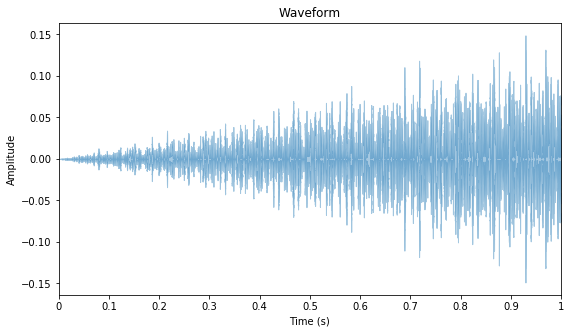

In [7]:
FIG_SIZE = (9, 5)
plt.figure(figsize = FIG_SIZE)
sample_audio = 1
waveplot_ = waveforms[sample_audio]
librosa.display.waveplot(waveplot_[0], sr = waveplot_[1], alpha = 0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

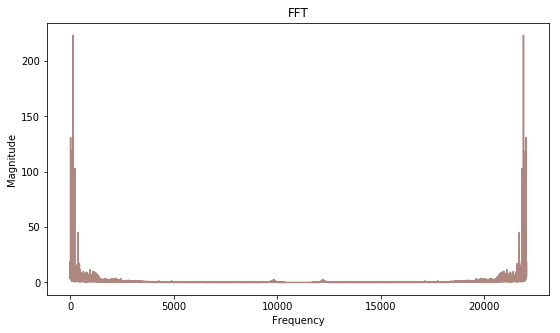

In [8]:
fourier1 = f_ffts[sample_audio]
plt.figure(figsize=FIG_SIZE)
plt.plot(fourier1[0], fourier1[1], alpha=0.7, color = "C5")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("FFT")
plt.show()

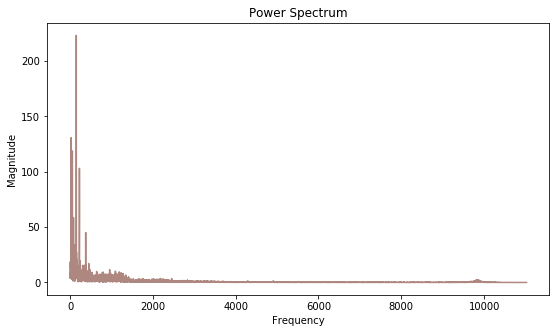

In [9]:
fourier2 = ffts[sample_audio]
plt.figure(figsize=FIG_SIZE)
plt.plot(fourier2[0], fourier2[1], alpha=0.7, color = "C5")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")
plt.show()

Text(0.5, 1.0, 'Spectrogram')

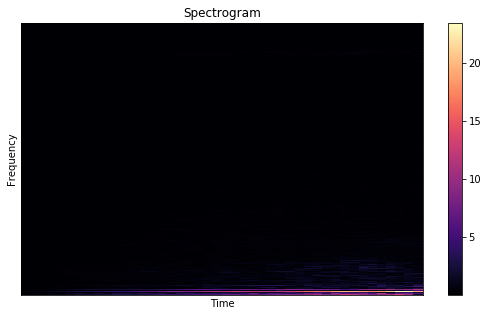

In [10]:
plt.figure(figsize = FIG_SIZE)
spectrogram_ = stfts[sample_audio]
librosa.display.specshow(spectrogram_[0], sr=spectrogram_[1], hop_length=spectrogram_[2])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

Text(0.5, 1.0, 'Log Spectrogram')

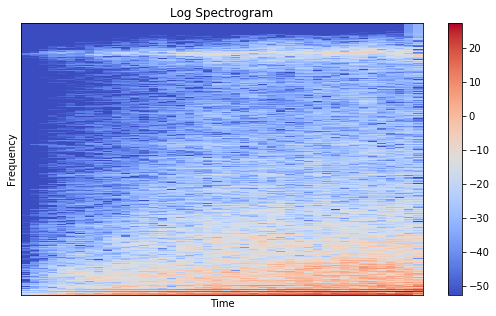

In [11]:
plt.figure(figsize = FIG_SIZE)
log_spectrogram_ = log_specs[sample_audio]
librosa.display.specshow(log_spectrogram_[0], sr=log_spectrogram_[1], hop_length=log_spectrogram_[2])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Log Spectrogram")

Text(0.5, 1.0, 'MFCCs')

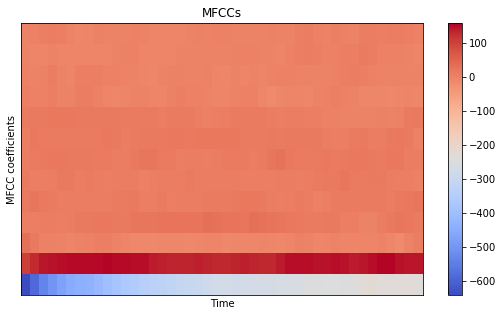

In [12]:
MFCCs_ = MFCCs_list[sample_audio]
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs_[0], sr=MFCCs_[1], hop_length=MFCCs_[2])
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")